# MIMIC-III

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


MIMIC-III is a relational database of heath-related data of patients at at critical care units of a medical center between 2001-2012. This full database can be found [here](https://physionet.org/content/mimiciii/1.4/), however the files we use here are: `ADMISSIONS.csv`, `LABEVENTS.csv`, `MICROBIOLOGY.csv` and `PRESCRIPTIONS.csv`.

Here, the files `LABEVENTS.csv`, `MICROBIOLOGY.csv` and `PRESCRIPTIONS.csv` all contain the associated hospital admission ID (`HADM_ID`) which we use to create a network. Within the admissions file, all the hospital admissions have a diagnosis associated with them which we use as labels. 

In [2]:
import pyemb as eb

### Data load

In [3]:
joining_col = 'HADM_ID'
data_names = ['micro', 'lab', 'pre']
dfs = {name: pd.read_csv('data/' + name + '.csv') for name in data_names}

# dfs['pre']['FORMULARY_DRUG_CD'] = dfs['pre']['FORMULARY_DRUG_CD'].astype(str)
# dfs['micro'] = dfs['micro'].dropna(subset=['ORG_ITEMID'])

/tmp/ipykernel_10719/1716424642.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = {name: pd.read_csv('data/' + name + '.csv') for name in data_names}


Create a dictionary of hospital admission IDs to diagnoses. 

In [4]:
adm = pd.read_csv('data/adm.csv')
hadm_to_diag = dict(zip(adm['HADM_ID'], adm['DIAGNOSIS']))
hadm_to_diag = {str(k): v for k, v in hadm_to_diag.items()}

In [5]:
pairs = [[joining_col, 'ORG_ITEMID'], [joining_col,
                                       'ITEMID'], [joining_col, 'FORMULARY_DRUG_CD']]

A, attributes = eb.graph_from_dataframes(list(dfs.values()), pairs)

3it [00:03,  1.09s/it]


In [6]:
sub_attr = [
    [{'partition': joining_col}],
    [{'partition': 'ORG_ITEMID'}, {'partition': 'ITEMID'},
        {'partition': 'FORMULARY_DRUG_CD'}]
]
subgraph_A, subgraph_attributes = eb.find_subgraph(A[0], attributes, sub_attr)

In [8]:
print('Number of rows:', subgraph_A.shape[0])

Number of rows: 57709


In [9]:
# get a random sample of the rows of subgraph_A 
n = 10000  
random_rows = np.random.choice(subgraph_A.shape[0], n, replace=False) 
subgraph_A = subgraph_A[random_rows, :]
subgraph_attributes = [list(np.array(subgraph_attributes[0])[random_rows]), subgraph_attributes[1]]

In [10]:
# ws, dim = eb.wasserstein_dimension_select(subgraph_A_sample, range(50), split=0.5)
# print("Selected dimension: {}".format(dim))
dim = 20

In [11]:
le = eb.embed(subgraph_A, dim, make_laplacian=True, regulariser= 'auto')

/home/ag16115/Documents/phd/pyemb/venv/lib/python3.10/site-packages/pyemb/embedding.py:129: UserWarning: Warning: More than one connected component in the graph.
  warnings.warn("Warning: More than one connected component in the graph.")


In [12]:
split_labels = [subgraph_attributes[0][i]['name'].split('::')[1] for i in range(subgraph_A.shape[0])]

labels = [str(hadm_to_diag[a]) for a in split_labels]

In [13]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
tsne = tsne.fit_transform(le)

In [14]:
labels_to_colour = {'BYPASS': 'darkseagreen', 'WITHDRAWAL': 'gold', 'MYOCARDIAL': 'lightpink', 'HEMORRHAGE': 'firebrick', 'CORONARY': 'powderblue', 'LEUKEMIA': 'plum', 'NEWBORN': 'coral'}

In [15]:
keywords = list(labels_to_colour.keys())
colours = []
# Loop through each label
for label in labels:
    found_keyword = None  # Track whether a keyword is found for this label
    for keyword in keywords:
        if keyword in label:  # Check if the keyword is in the label
            found_keyword = keyword  # Store the matching keyword
            break  # Exit the loop once a match is found

    # Add the label to the dictionary, even if no keyword is found
    if found_keyword:
        colours.append(labels_to_colour[found_keyword])
    else:
        colours.append('darkgrey')

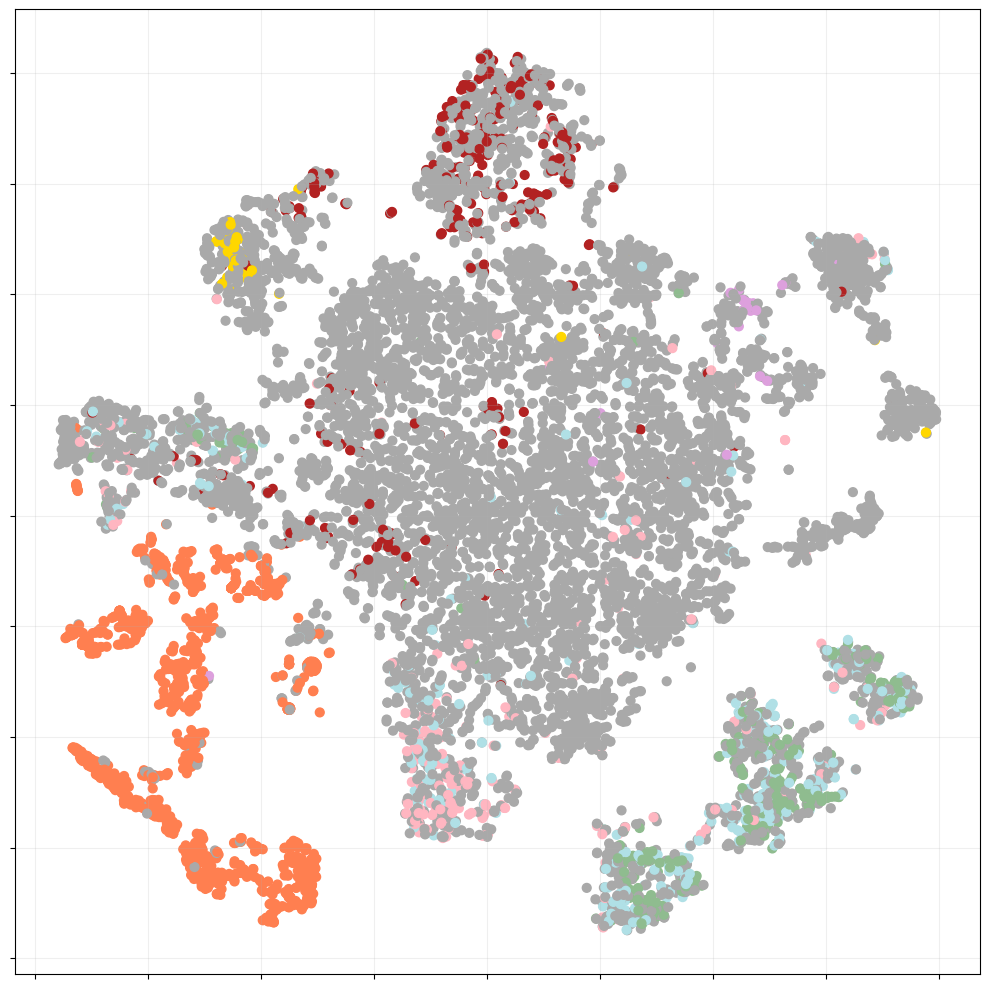

In [16]:
pca_fig = eb.snapshot_plot(
    embedding = tsne, 
    # node_labels = labels, 
    c = colours,
    # title = ['PCA','tSNE'],
    add_legend=False, 
    # Apply other matplotlib settings
    figsize = (10, 10),

    s=40,
)
plt.tight_layout()